In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import os

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Get current working directory
print("Current working directory:", os.getcwd())

# Construct absolute paths
base_dir = os.path.dirname(os.getcwd())  # Go up one level from notebooks
data_path = os.path.join(base_dir, 'results_run6')

si_path = os.path.join(data_path, 'small_matrix_si_influence.csv')
sir_path = os.path.join(data_path, 'small_matrix_sir_influence.csv')

print("SI file exists:", os.path.exists(si_path))
print("SIR file exists:", os.path.exists(sir_path))

# Then load with these paths
si_data = pd.read_csv(si_path)
sir_data = pd.read_csv(sir_path)

print("SI Data columns:", si_data.columns.tolist())
print("SIR Data columns:", sir_data.columns.tolist())
print(f"SI data shape: {si_data.shape}")
print(f"SIR data shape: {sir_data.shape}")

# Since network metrics are the same, we'll use the ones from SI data
# Rename columns to avoid conflicts during merge
si_data_renamed = si_data.rename(columns={
    'strength': 'strength',
    'pagerank': 'pagerank'
})

sir_data_renamed = sir_data.rename(columns={
    'strength': 'strength_sir',  # Temporary, will be dropped
    'pagerank': 'pagerank_sir'   # Temporary, will be dropped
})

# Merge the datasets on user_id
merged_data = pd.merge(si_data_renamed, sir_data_renamed, on='user_id', suffixes=('', '_sir'))

# Drop the duplicate network metrics from SIR data since they're the same
merged_data = merged_data.drop(['strength_sir', 'pagerank_sir'], axis=1)

print(f"Merged data shape: {merged_data.shape}")
print("\nFirst few rows of merged data:")
print(merged_data.head())

Current working directory: c:\Users\danie\Documents\Local_Gits\complex-networks\notebooks
SI file exists: True
SIR file exists: True
SI Data columns: ['user_id', 'time_to_10', 'time_to_25', 'time_to_50', 'time_to_90', 'std_time_10', 'std_time_25', 'std_time_50', 'final_size', 'strength', 'pagerank']
SIR Data columns: ['user_id', 'final_outbreak', 'std_outbreak', 'attack_rate', 'epidemic_probability', 'peak_infection', 'time_to_peak', 'duration', 'R0', 'growth_rate', 'strength', 'pagerank']
SI data shape: (1157, 11)
SIR data shape: (1157, 12)
Merged data shape: (1157, 20)

First few rows of merged data:
   user_id  time_to_10  time_to_25  time_to_50  time_to_90  std_time_10  \
0      136         1.0         1.0         1.0         1.0          0.0   
1     7007         1.0         1.0         1.0         1.0          0.0   
2     6736         1.0         1.0         1.0         1.0          0.0   
3     6330         1.0         1.0         1.0         1.0          0.0   
4     6435     

In [3]:
# Define the metrics we want to analyze
si_metrics = ['time_to_10', 'time_to_25', 'time_to_50', 'time_to_90', 
              'std_time_10', 'std_time_25', 'std_time_50', 'final_size']

sir_metrics = ['final_outbreak', 'std_outbreak', 'attack_rate', 
               'epidemic_probability', 'peak_infection', 'time_to_peak', 
               'duration', 'R0', 'growth_rate']

network_metrics = ['strength', 'pagerank']  # Same for both models

In [9]:
# Function to calculate correlations
def calculate_correlations(data, metrics1, metrics2, method='pearson'):
    """Calculate correlations between two sets of metrics"""
    correlations = []
    
    for metric1 in metrics1:
        for metric2 in metrics2:
            # Remove any rows with NaN values for these two metrics
            clean_data = data[[metric1, metric2]].dropna()
            
            if len(clean_data) > 1:  # Need at least 2 points for correlation
                if method == 'pearson':
                    corr, p_value = pearsonr(clean_data[metric1], clean_data[metric2])
                else:  # spearman
                    corr, p_value = spearmanr(clean_data[metric1], clean_data[metric2])
                
                correlations.append({
                    'metric1': metric1,
                    'metric2': metric2,
                    'correlation': corr,
                    'p_value': p_value,
                    'n_samples': len(clean_data)
                })
    
    return pd.DataFrame(correlations)

# Calculate correlations with network metrics as predictors (x-axis)
print("Calculating correlations: Network metrics vs SI outcomes...")
network_si_corr = calculate_correlations(merged_data, network_metrics, si_metrics)
network_si_corr_sorted = network_si_corr.sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 Network-SI correlations (absolute value):")
print(network_si_corr_sorted.head(10).to_string(index=False))

print("\nCalculating correlations: Network metrics vs SIR outcomes...")
network_sir_corr = calculate_correlations(merged_data, network_metrics, sir_metrics)
network_sir_corr_sorted = network_sir_corr.sort_values('correlation', key=abs, ascending=False)

print("\nTop 10 Network-SIR correlations (absolute value):")
print(network_sir_corr_sorted.head(10).to_string(index=False))

Calculating correlations: Network metrics vs SI outcomes...

Top 10 Network-SI correlations (absolute value):
 metric1     metric2  correlation       p_value  n_samples
strength  final_size     0.700007 4.386022e-171       1157
pagerank  final_size     0.670059 1.171196e-151       1157
strength  time_to_90     0.662578 3.720453e-147       1157
pagerank std_time_10    -0.661356 1.966418e-146       1157
strength std_time_10    -0.656367 1.624641e-143       1157
strength std_time_50    -0.652069 4.777763e-141       1157
pagerank std_time_50    -0.637331 7.027997e-133       1157
pagerank  time_to_90     0.633121 1.254957e-130       1157
strength  time_to_25     0.591604 3.606586e-110       1157
strength  time_to_50     0.564296  2.953855e-98       1157

Calculating correlations: Network metrics vs SIR outcomes...

Top 10 Network-SIR correlations (absolute value):
 metric1              metric2  correlation       p_value  n_samples
strength                   R0     0.961965  0.000000e+00    


Plotting top correlations: Network metrics predicting SI outcomes...


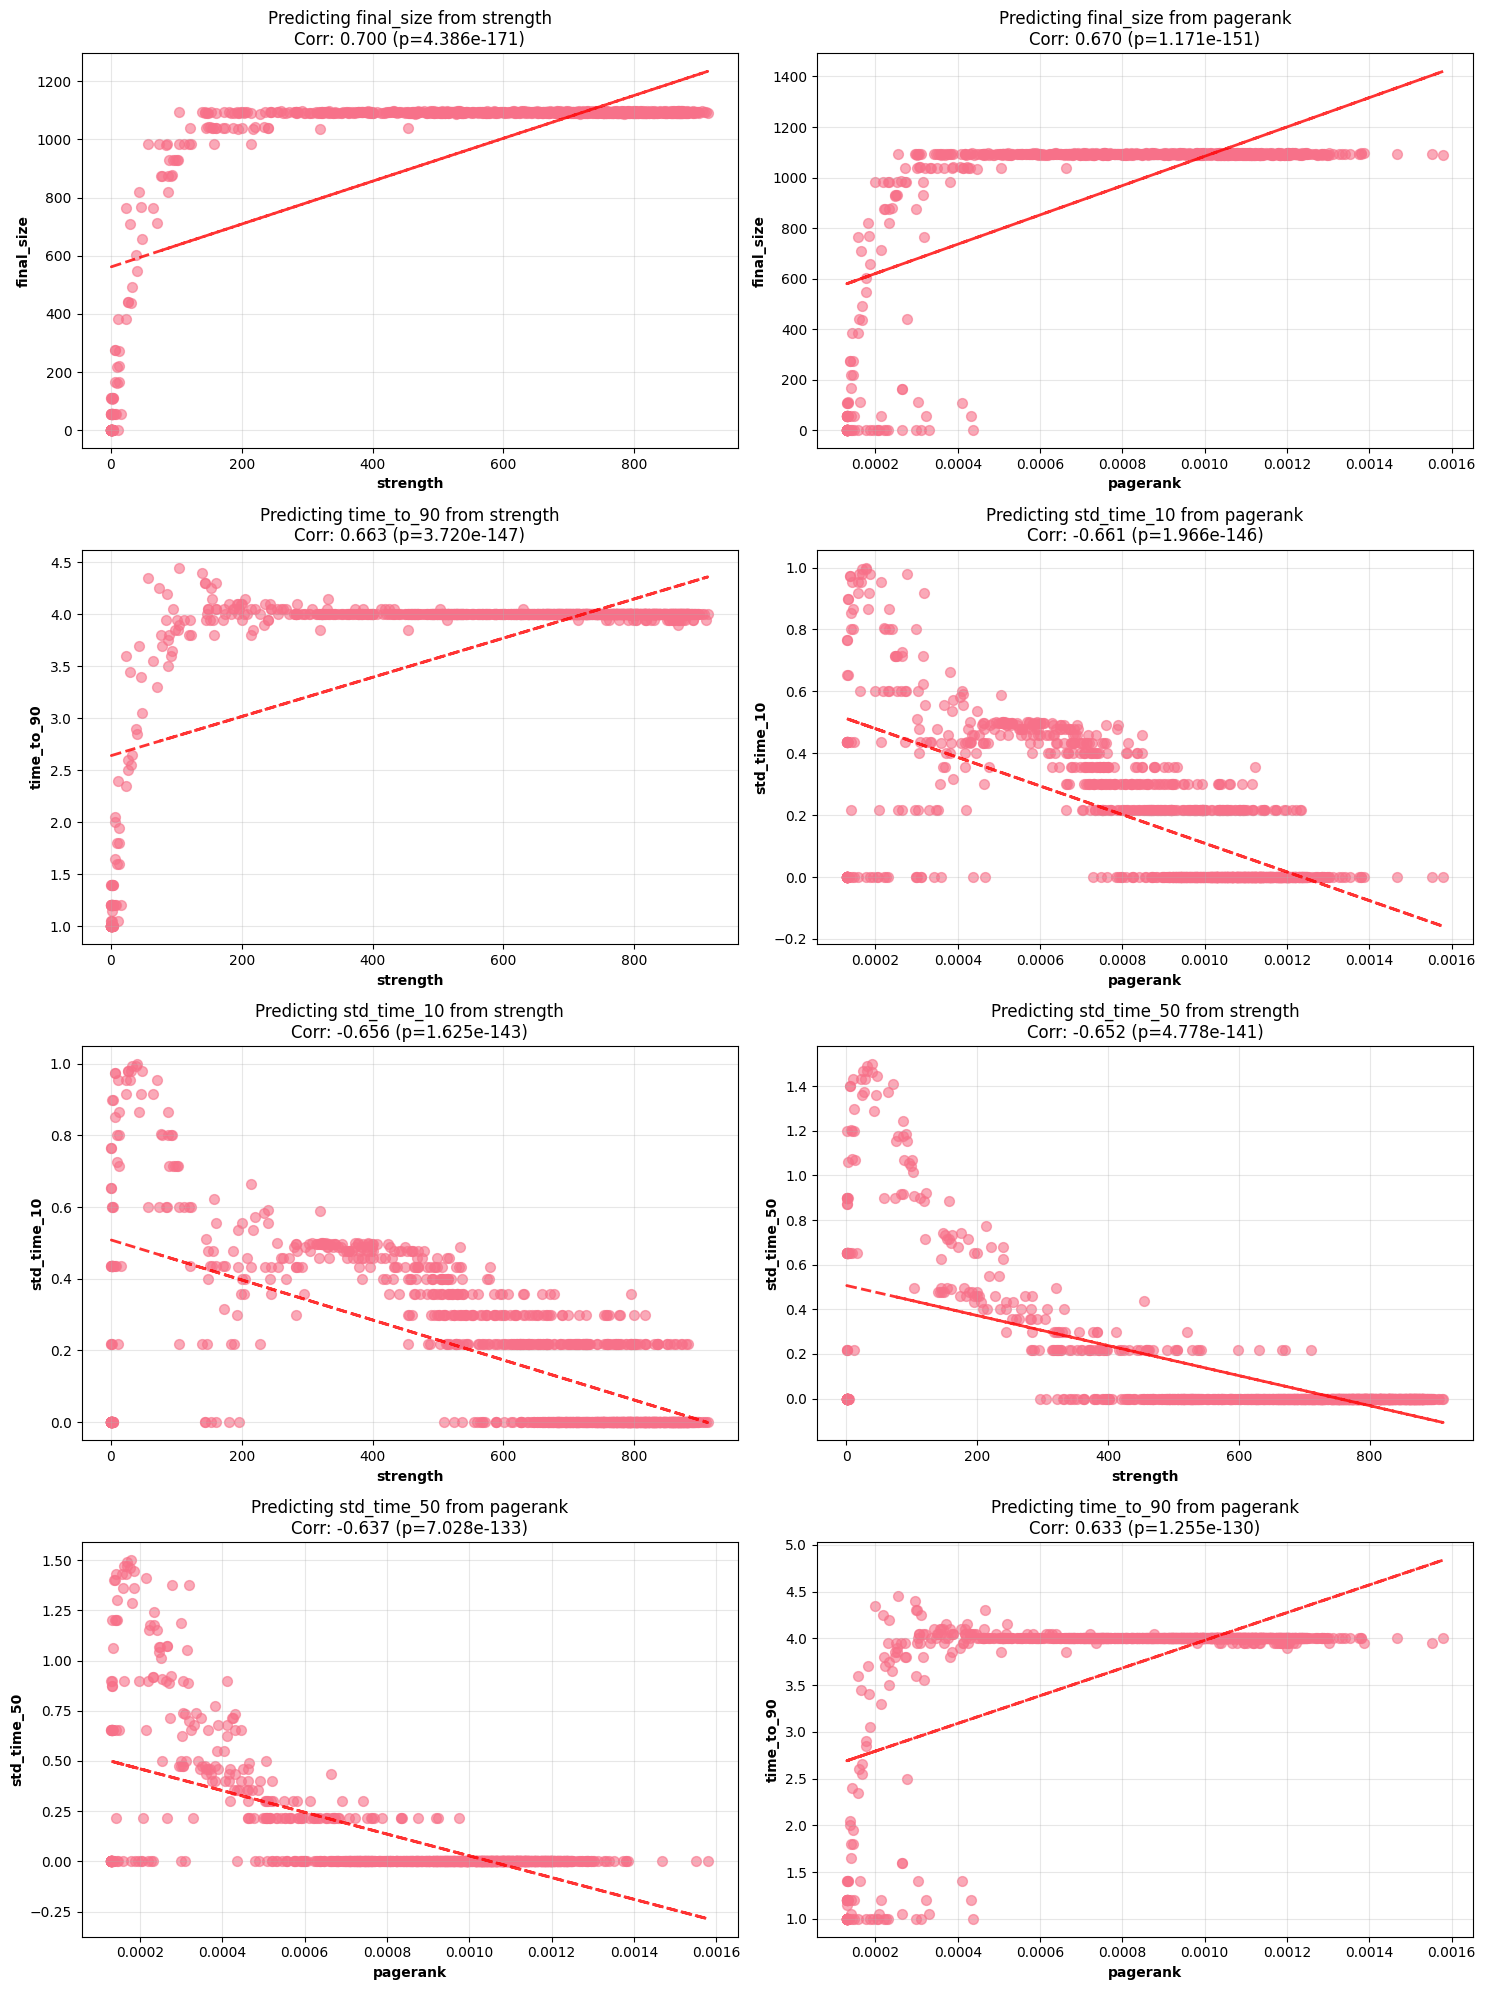


Plotting top correlations: Network metrics predicting SIR outcomes...


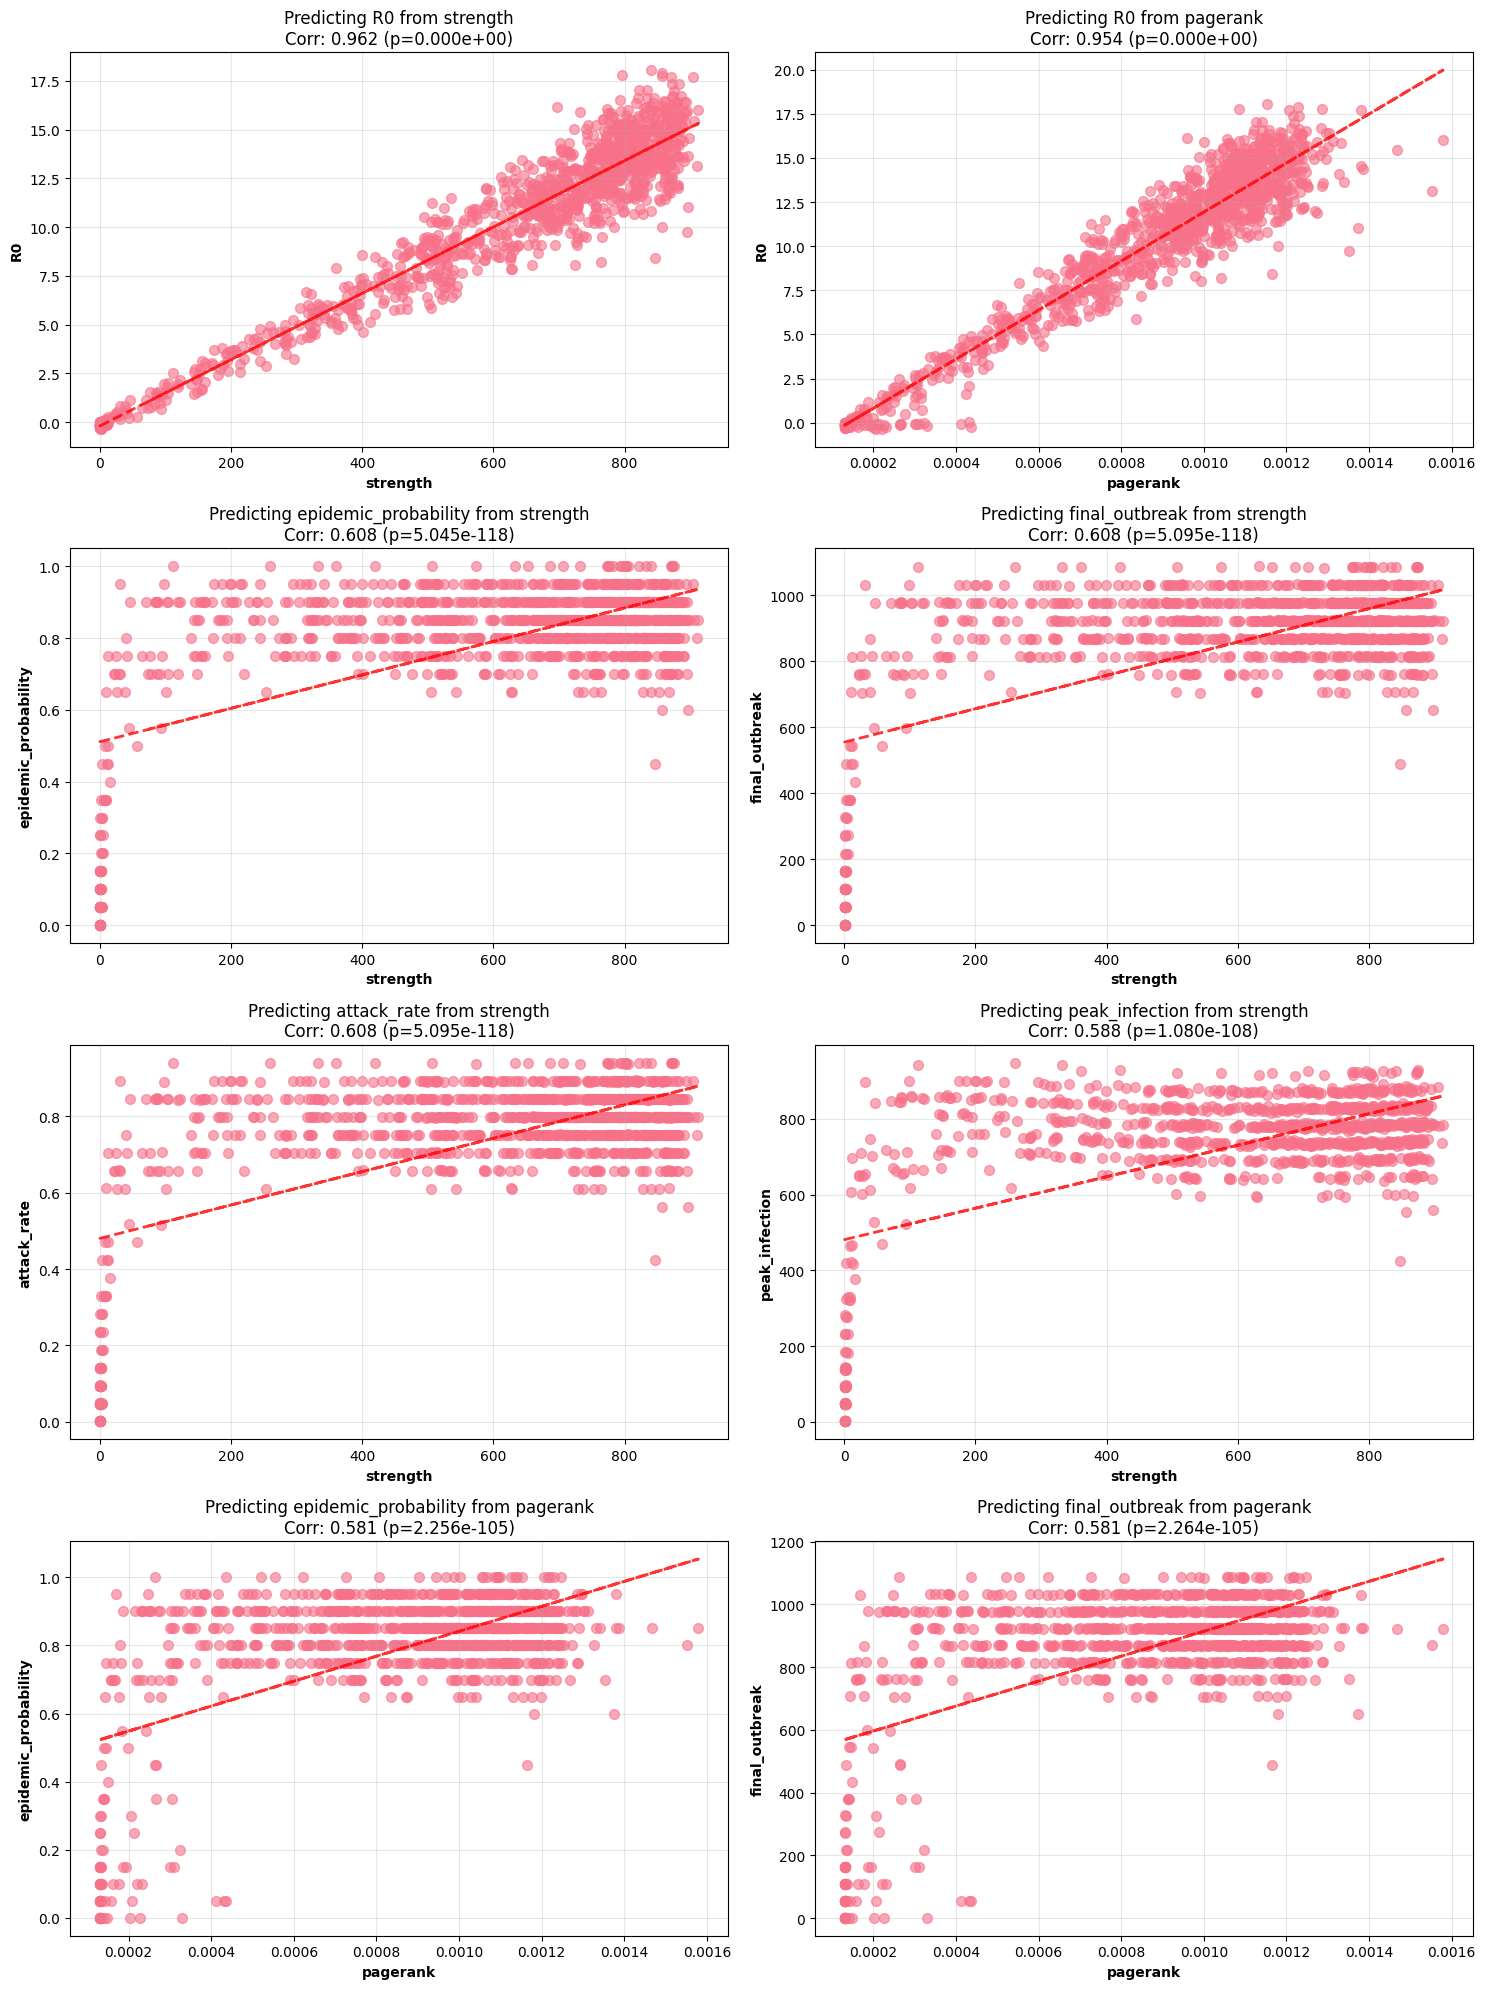

In [17]:
# Function to create scatter plots with network metrics on x-axis
def plot_network_predictions(data, correlation_df, top_n=8):
    """Plot scatter plots with network metrics as predictors (x-axis)"""
    top_correlations = correlation_df.head(top_n)
    
    n_plots = len(top_correlations)
    n_cols = 2
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_plots > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, (_, row) in enumerate(top_correlations.iterrows()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        network_metric = row['metric1']  # Network metric on x-axis
        outcome_metric = row['metric2']  # Simulation outcome on y-axis
        corr = row['correlation']
        p_val = row['p_value']
        
        clean_data = data[[network_metric, outcome_metric]].dropna()
        
        ax.scatter(clean_data[network_metric], clean_data[outcome_metric], alpha=0.6, s=50)
        ax.set_xlabel(network_metric, fontweight='bold')
        ax.set_ylabel(outcome_metric, fontweight='bold')
        ax.set_title(f'Predicting {outcome_metric} from {network_metric}\nCorr: {corr:.3f} (p={p_val:.3e})')
        
        # Add trend line
        if len(clean_data) > 1:
            z = np.polyfit(clean_data[network_metric], clean_data[outcome_metric], 1)
            p = np.poly1d(z)
            ax.plot(clean_data[network_metric], p(clean_data[network_metric]), "r--", alpha=0.8, linewidth=2)
        
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(len(top_correlations), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot network metrics as predictors
print("\nPlotting top correlations: Network metrics predicting SI outcomes...")
plot_network_predictions(merged_data, network_si_corr_sorted)

print("\nPlotting top correlations: Network metrics predicting SIR outcomes...")
plot_network_predictions(merged_data, network_sir_corr_sorted)


Creating enhanced correlation heatmap...


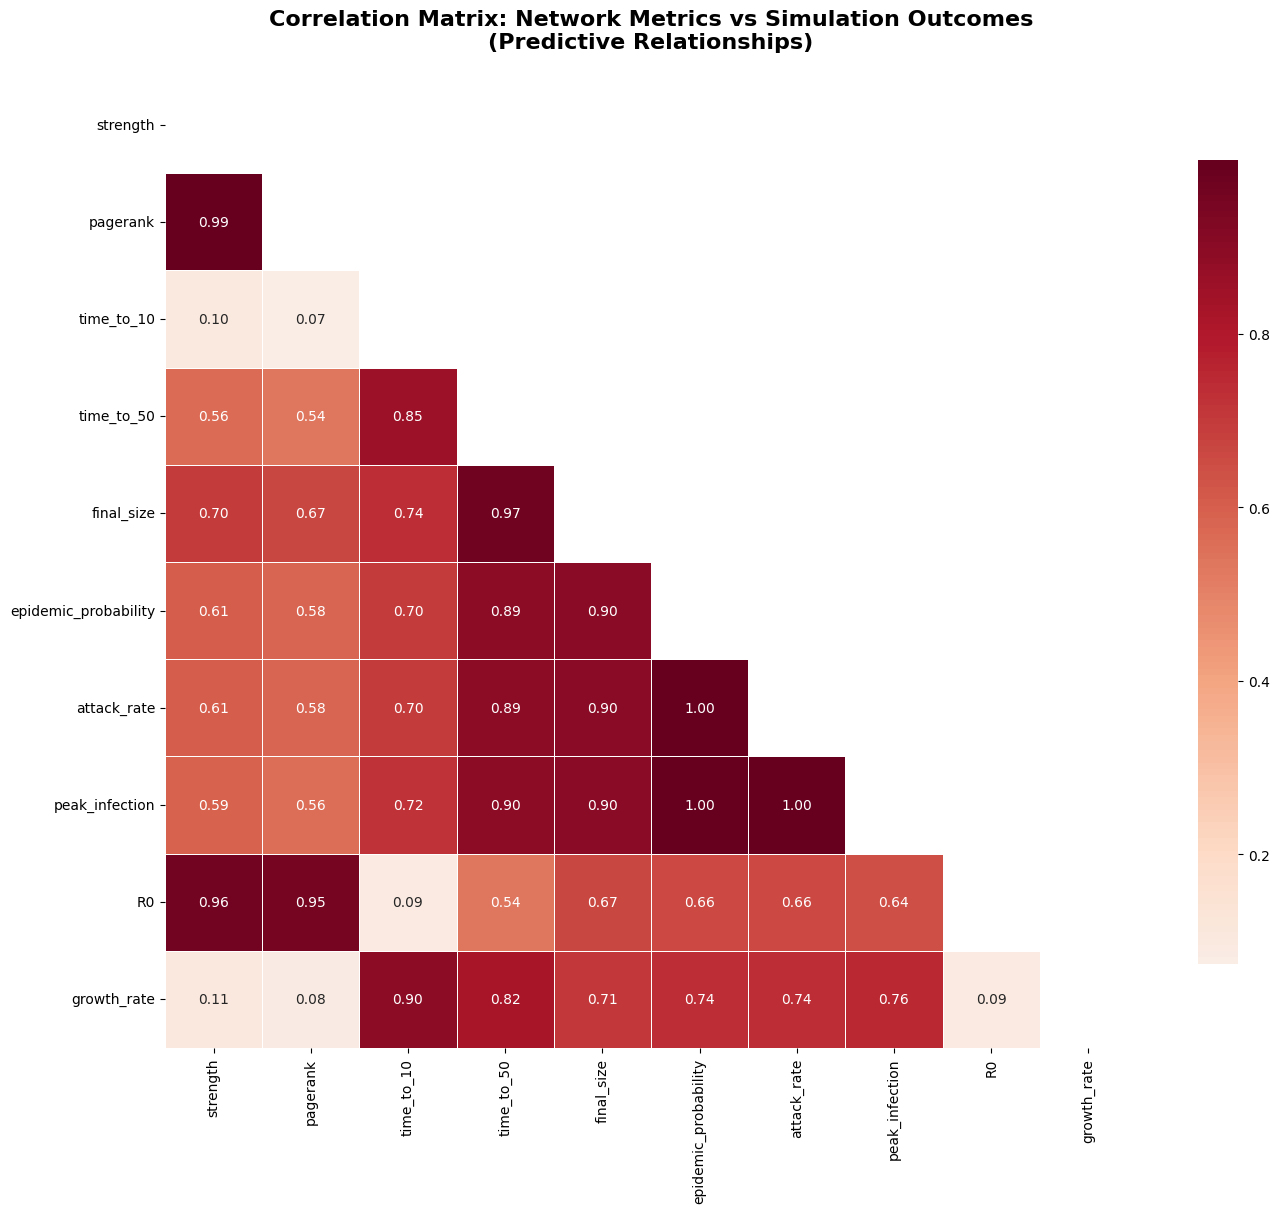


HEATMAP INTERPRETATION GUIDE:

Strongest correlations with network metrics (|r| > 0.5):
  strength ↔ R0: r = 0.962 (positive)
  pagerank ↔ R0: r = 0.954 (positive)
  strength ↔ final_size: r = 0.700 (positive)
  pagerank ↔ final_size: r = 0.670 (positive)
  strength ↔ epidemic_probability: r = 0.608 (positive)
  strength ↔ attack_rate: r = 0.608 (positive)
  strength ↔ peak_infection: r = 0.588 (positive)
  pagerank ↔ epidemic_probability: r = 0.581 (positive)
  pagerank ↔ attack_rate: r = 0.581 (positive)
  strength ↔ time_to_50: r = 0.564 (positive)
  pagerank ↔ peak_infection: r = 0.562 (positive)
  pagerank ↔ time_to_50: r = 0.536 (positive)

Moderate correlations with network metrics (0.3 < |r| < 0.5):
  No moderate correlations found


In [18]:
# Enhanced correlation heatmap with better insights
print("\nCreating enhanced correlation heatmap...")

# Select key metrics for the heatmap - focusing on predictive relationships
key_metrics_enhanced = [
    # Network metrics (predictors) - placed first
    'strength', 'pagerank',
    # SI outcomes
    'time_to_10', 'time_to_50', 'final_size',
    # SIR outcomes
    'epidemic_probability', 'attack_rate', 'peak_infection', 'R0', 'growth_rate'
]

# Filter to only include columns that exist in the data
available_metrics_enhanced = [m for m in key_metrics_enhanced if m in merged_data.columns]

# Calculate correlation matrix
corr_matrix_enhanced = merged_data[available_metrics_enhanced].corr()

# Create the heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix_enhanced, dtype=bool))

# Create heatmap with better formatting
sns.heatmap(corr_matrix_enhanced, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8},
            annot_kws={'size': 10}, linewidths=0.5)

plt.title('Correlation Matrix: Network Metrics vs Simulation Outcomes\n(Predictive Relationships)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print key insights from the heatmap
print("\n" + "="*60)
print("HEATMAP INTERPRETATION GUIDE:")
print("="*60)

# Extract network metric correlations
network_section = corr_matrix_enhanced.loc[['strength', 'pagerank'], :]

print("\nStrongest correlations with network metrics (|r| > 0.5):")
strong_corrs = []
for network_metric in ['strength', 'pagerank']:
    for outcome in available_metrics_enhanced:
        if outcome not in ['strength', 'pagerank']:
            corr_val = corr_matrix_enhanced.loc[network_metric, outcome]
            if abs(corr_val) > 0.5 and not pd.isna(corr_val):
                strong_corrs.append((network_metric, outcome, corr_val))

if strong_corrs:
    for net_metric, outcome, corr in sorted(strong_corrs, key=lambda x: abs(x[2]), reverse=True):
        direction = "positive" if corr > 0 else "negative"
        print(f"  {net_metric} ↔ {outcome}: r = {corr:.3f} ({direction})")
else:
    print("  No very strong correlations found (|r| > 0.5)")

print("\nModerate correlations with network metrics (0.3 < |r| < 0.5):")
moderate_corrs = []
for network_metric in ['strength', 'pagerank']:
    for outcome in available_metrics_enhanced:
        if outcome not in ['strength', 'pagerank']:
            corr_val = corr_matrix_enhanced.loc[network_metric, outcome]
            if 0.3 < abs(corr_val) <= 0.5 and not pd.isna(corr_val):
                moderate_corrs.append((network_metric, outcome, corr_val))

if moderate_corrs:
    for net_metric, outcome, corr in sorted(moderate_corrs, key=lambda x: abs(x[2]), reverse=True):
        direction = "positive" if corr > 0 else "negative"
        print(f"  {net_metric} ↔ {outcome}: r = {corr:.3f} ({direction})")
else:
    print("  No moderate correlations found")

In [13]:
# Create a summary table of predictive power
print("\n" + "="*80)
print("SUMMARY: Predictive Power of Network Metrics")
print("="*80)

# Create summary dataframe
summary_data = []
for network_metric in network_metrics:
    for outcome in key_si_outcomes + key_sir_outcomes:
        if outcome in merged_data.columns:
            clean_data = merged_data[[network_metric, outcome]].dropna()
            if len(clean_data) > 1:
                corr, p_val = pearsonr(clean_data[network_metric], clean_data[outcome])
                r_squared = corr ** 2
                summary_data.append({
                    'Predictor': network_metric,
                    'Outcome': outcome,
                    'Correlation (r)': f"{corr:.3f}",
                    'R-squared': f"{r_squared:.3f}",
                    'p-value': f"{p_val:.3e}",
                    'Strength': 'Strong' if abs(corr) > 0.7 else 
                               'Moderate' if abs(corr) > 0.5 else 
                               'Weak' if abs(corr) > 0.3 else 'Very Weak'
                })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('R-squared', ascending=False)

print("\nPredictive Performance Summary (sorted by R-squared):")
print(summary_df.to_string(index=False))

# Print best predictors
print("\n" + "="*50)
print("BEST PREDICTORS (R-squared > 0.1)")
print("="*50)
strong_predictors = summary_df[summary_df['R-squared'].astype(float) > 0.1]
if len(strong_predictors) > 0:
    print(strong_predictors.to_string(index=False))
else:
    print("No strong predictors found (R-squared > 0.1)")


SUMMARY: Predictive Power of Network Metrics

Predictive Performance Summary (sorted by R-squared):
Predictor              Outcome Correlation (r) R-squared    p-value  Strength
 strength                   R0           0.962     0.925  0.000e+00    Strong
 pagerank                   R0           0.954     0.910  0.000e+00    Strong
 strength           final_size           0.700     0.490 4.386e-171    Strong
 pagerank           final_size           0.670     0.449 1.171e-151  Moderate
 strength epidemic_probability           0.608     0.370 5.045e-118  Moderate
 strength          attack_rate           0.608     0.370 5.095e-118  Moderate
 strength       peak_infection           0.588     0.346 1.080e-108  Moderate
 pagerank epidemic_probability           0.581     0.337 2.256e-105  Moderate
 pagerank          attack_rate           0.581     0.337 2.264e-105  Moderate
 strength           time_to_50           0.564     0.318  2.954e-98  Moderate
 pagerank       peak_infection           